In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyopenjtalk
import pyworld as pw
from nnmnkwii.io import hts
from scipy.io.wavfile import write
from scipy.signal import savgol_filter
import sounddevice as sd

import ttslearn
from ttslearn.dnntts import DNNTTS
from ttslearn.util import init_seed, lab2phonemes
from ttslearn.dnntts.gen import gen_waveform, predict_acoustic, predict_duration

import PySimpleGUI as sg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# fix the seed
init_seed(773)

In [2]:
# create class for DNNTTS
class myDNNTTS(DNNTTS):
    def __init__(self, model_dir=None, device="cpu"):
        super().__init__(model_dir=model_dir, device=device)

    def __repr__(self):
        return super().__repr__()

    def set_device(self, device):
        return super().set_device(device)
    
    def post_process(self, wav):
        return super().post_process(wav)
    
    @torch.no_grad()
    def tts(self, text, post_filter=True, tqdm=None):
        # extract full context
        contexts = pyopenjtalk.extract_fullcontext(text)

        # convert to HTS format
        if hasattr(hts.HTSLabelFile, "create_from_contexts"):
            labels = hts.HTSLabelFile.create_from_contexts(contexts)
        else:
            labels = hts.load(None, contexts)

        # predict phoneme durations
        durations = predict_duration(
            self.device, labels, self.duration_model, self.duration_config,
            self.duration_in_scaler, self.duration_out_scaler, self.binary_dict,
            self.numeric_dict
        )
        labels.set_durations(durations)

        # predict acoustic features
        acoustic_features = predict_acoustic(
            self.device, labels, self.acoustic_model, self.acoustic_config,
            self.acoustic_in_scaler, self.acoustic_out_scaler, self.binary_dict,
            self.numeric_dict
        )

        # synthesize wavefrom
        wav = gen_waveform(
            self.sample_rate, acoustic_features, self.acoustic_config.stream_sizes,
            self.acoustic_config.has_dynamic_features, self.acoustic_config.num_windows,
            post_filter=post_filter
        )

        return self.post_process(wav), self.sample_rate, labels

In [3]:
# extract features from waveform
def extract_feats(text):
    engine = myDNNTTS()
    wav, sr, labels = engine.tts(text)
    # extract phonemes
    phonemes = lab2phonemes(labels)
    # extract f0, spectrogram, aperiodicity 
    wav = wav.astype(np.float)
    f0, t = pw.harvest(wav, sr)
    sp = pw.cheaptrick(wav, f0, t, sr)
    ap = pw.d4c(wav, f0, t, sr)

    return wav, labels, phonemes, f0, t, sp, ap, sr

In [4]:
# extract corresponding time from original wav
def get_phoneme_alignment(labels, phonemes):
    start_times = [label[0] * 1e-7 for label in labels]
    end_times = [label[1] * 1e-7 for label in labels]
    phoneme_times = [(phoneme, start_time, end_time) for phoneme, start_time, end_time 
                     in zip(*(phonemes, start_times, end_times))]
    
    return phoneme_times

In [5]:
# extract romaji of utterances
def phoneme2romaji(phonemes):
    tmp_phonemes = phonemes.copy()
    while "sil" in tmp_phonemes:
        tmp_phonemes.remove("sil")
    while "pau" in tmp_phonemes:
        tmp_phonemes.remove("pau")

    romaji_text = []
    tmp = ""
    for p in tmp_phonemes:
        tmp += p
        if p in "aiueoIN":
            romaji_text.append(tmp)
            tmp = ""
    
    return romaji_text

In [6]:
# extract vowel and start/end time
def get_vowel_alignment(phoneme_times):
    vowels = []
    for phoneme, start_time, end_time in phoneme_times:
        if phoneme in "aiueoIN":
            vowels.append((phoneme, start_time, end_time))
    
    return vowels

In [7]:
# extract romaji and start/end time
def get_romaji_alignment(phoneme_times):
    romajis = []
    only_vowel = True  # flag to check if romaji is composed of only vowel
    for phoneme, start_time, end_time in phoneme_times:
        if phoneme in "aiueoIN":
            if only_vowel:
                romajis.append((phoneme, start_time, end_time))
            else:
                romajis.append((phoneme, tmp_start_time, end_time))
                only_vowel = True
        else:
            tmp_start_time = start_time  # save consonant's start time
            only_vowel = False
    
    return romajis

In [8]:
# calculate corresponding indices of f0
def get_f0_indices(wav, f0, sr, alignment_arr):
    alignment_arr_indices = []
    for phoneme, start_time, end_time in alignment_arr:
        start_index = int(len(f0) * start_time * sr / len(wav))
        end_index = int(len(f0) * end_time * sr / len(wav))
        alignment_arr_indices.append((phoneme, start_index, end_index))

    return alignment_arr_indices

In [9]:
# draw figure (for GUI)
def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

# modify f0 to desired accent (for GUI)
def modify_f0(event, values, romaji_indices, f0):
    for i, (phoneme, start_index, end_index) in enumerate(romaji_indices):
        if event[6:] == str(i):
            f0[start_index:end_index] = values[f"slider{i}"]  # change f0 of vowel
            break

# smoothing f0 by Savitzky-Golay filter
def smooth_f0(f0):
    f0 = savgol_filter(f0, 11, 3)  # window length = 11, polyorder = 3
    f0 = np.where(f0 < 0, 0, f0)  # f0 shouldn't be negative
    return f0

In [10]:
wav, labels, phonemes, f0, t, sp, ap, sr = extract_feats("合成した音声のアクセントを修正できます")
phoneme_times = get_phoneme_alignment(labels, phonemes)
vowels = get_vowel_alignment(phoneme_times)
romajis = get_romaji_alignment(phoneme_times)
vowel_indices = get_f0_indices(wav, f0, sr, vowels)
romaji_indices = get_f0_indices(wav, f0, sr, romajis)

In [11]:
# create new window to modify f0
def modify_window(wav, labels, phonemes, f0, t, sp, ap, sr, vowel_indices, romaji_indices):
    # theme
    sg.theme("DarkGrey6")

    # sliders
    sliders = []
    for i, (phoneme, start_index, end_index) in enumerate(vowel_indices):
        slider = sg.Slider(range=(0, int(max(f0))), default_value=int(f0[start_index]),
                        resolution=10, orientation="v", size=(5, 5), font=(None, 10),
                        enable_events=True, key=f"slider{i}")
        sliders.append(slider)
    # buttons
    buttons = [
        [sg.Button("Play Original", key="play_original")], 
        [sg.Button("Play Modified", key="play_modified")],
        [sg.Button("Smoothing", key="smoothing")],
        [sg.Button("Save Modified", key="save_modified")]
    ]
    # layout
    modify_window_layout = [
        [sg.Canvas(key='-CANVAS-')],
        [sg.Column([sliders]), sg.Column(buttons)],
        [sg.Text((" "*7).join(phoneme2romaji(phonemes)) + " "*35, font=(None, 10))]
    ]

    # create window
    modify_window = sg.Window(
        'Accent Modifier', modify_window_layout, modal=True, finalize=True, 
        element_justification='center', font='Monospace 18', location=(400, 100)
    )

    # create embedded figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_ylim(-20, max(f0) + 20)
    # associate figure with canvas
    fig_agg = draw_figure(modify_window["-CANVAS-"].TKCanvas, fig)

    # main loop
    while True:
        event, values = modify_window.read()

        if event == None:
            break

        elif event[:6] == "slider":
            ax.cla()  # clear previous figure
            modify_f0(event, values, romaji_indices, f0)
            # draw new figure
            ax.plot(t, f0)
            ax.set_ylabel("Frequency [Hz]")
            ax.set_ylim(-20, max(f0) + 20)
            ax.set_xticks([label[0] * 1e-7 for label in labels])
            ax.set_xticklabels(phonemes)
            fig_agg.draw()
        
        elif event == "play_original":
            sd.play(wav.astype(np.int16), sr)
            sd.wait() 
            sd.stop()
        
        elif event == "play_modified":
            gen_wav = pw.synthesize(f0, sp, ap, sr)
            gen_wav = gen_wav.astype(np.int16)
            sd.play(gen_wav, sr)
            sd.wait() 
            sd.stop()
        
        elif event == "smoothing":
            ax.cla()  # clear previous figure
            f0 = smooth_f0(f0)  # smoothing
            # draw new figure
            ax.plot(t, f0)
            ax.set_ylabel("Frequency [Hz]")
            ax.set_ylim(-20, max(f0) + 20)
            ax.set_xticks([label[0] * 1e-7 for label in labels])
            ax.set_xticklabels(phonemes)
            fig_agg.draw()
        
        elif event == "save_modified":
            gen_wav = pw.synthesize(f0, sp, ap, sr)
            gen_wav = gen_wav.astype(np.int16)
            write("../wavfile/modified.wav", sr, gen_wav)
        
    modify_window.close()

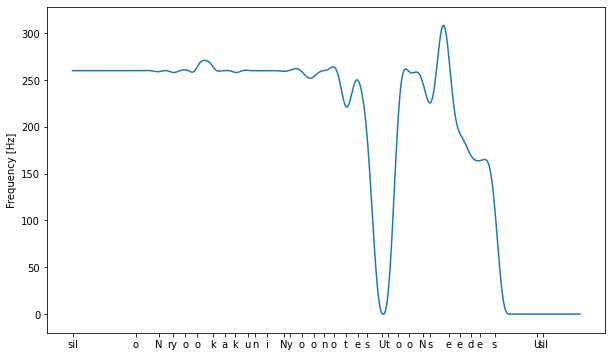

In [12]:
# theme
sg.theme("DarkGrey6")

# layout
layout = [
    [
        sg.Text("Text you want to synthesize:"), 
        sg.InputText(size=(20, 1), key="text"),
        sg.Button("Extract Features", key="extract_feats")
    ],
]

# create window
window = sg.Window(
    'Accent Modifier', layout, finalize=True, element_justification='center', 
    font='Monospace 18', location=(400, 100)
)

# main loop
while True:
    event, values = window.read()

    if event == None:
        break

    elif event == "extract_feats" and values["text"] != "":
        wav, labels, phonemes, f0, t, sp, ap, sr = extract_feats(values["text"])
        phoneme_times = get_phoneme_alignment(labels, phonemes)
        romaji_text = phoneme2romaji(phonemes)
        vowels = get_vowel_alignment(phoneme_times)
        romajis = get_romaji_alignment(phoneme_times)
        vowel_indices = get_f0_indices(wav, f0, sr, vowels)
        romaji_indices = get_f0_indices(wav, f0, sr, romajis)
        modify_window(wav, labels, phonemes, f0, t, sp, ap, sr, vowel_indices, romaji_indices)

window.close()